# Worm Mask Exploration

## Goal: explore potentail segmentation models for worm/no worm classification


References:
1. Bhattiprolu (segmentation resources)
2. Ronneberger, Fischer, Brox (Unet)

In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import datetime
from keras.optimizers import Adam
from keras.metrics import MeanIoU

import sys
import os
import datetime

## Reading in the data
Input: worm_imgs is a tiff file of full worm images

Input: mask_imgs is a tiff file of those same images with the binary worm/no worm mask

Only training 30 images

In [9]:
worm_imgs = tifffile.imread('single_worms_set2_30im.tiff')
mask_imgs = tifffile.imread('masks_set2_30im.tiff')
worm_imgs.shape
mask_imgs.shape

(30, 512, 512)

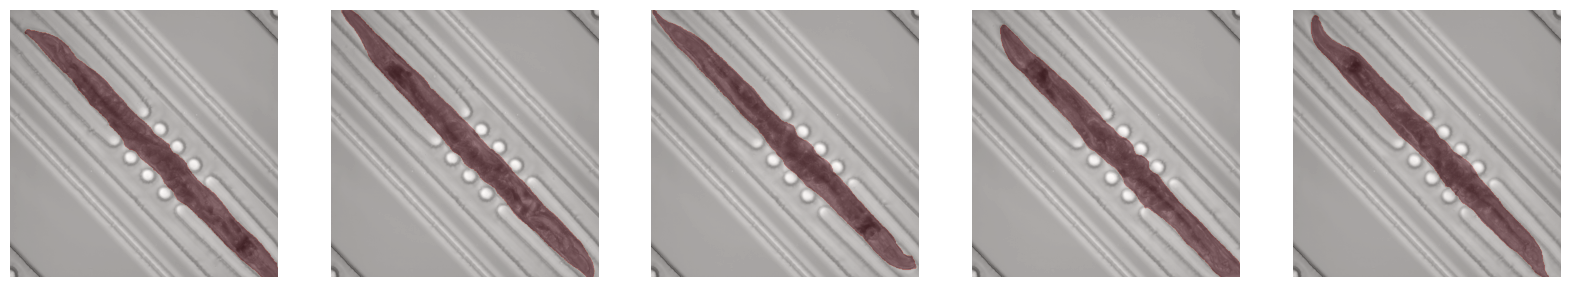

In [10]:
# Plotting a few images and masks to make sure they align
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images
    axs[i].imshow(worm_imgs[i], cmap='gray')

    # show mask overlay
    # cmap='Reds' makes the mask red
    # alpha sets the transparency level (0 is fully transparent, 1 is fully opaque)
    axs[i].imshow(mask_imgs[i], cmap='Reds', alpha=0.3)
    axs[i].axis('off')  # hide the axes

plt.show()

## Patches

- We think we can use patches to "increase" the size of our dataset. We don't necessarily think that the context of the full worm is needed to segment worm/no worm.
- We can use extract_patches to get patches of size 128*128
- We noticed that many patches have no worm in them. We removed some (not all) of the empty patches to create a more balanced dataset.
- We started with 30 images of 512x512, turned that into 1470 patches of 128x128, and then downsampled that to 462 train and 155 test (25% validation).


In [11]:
mask_patches = tf.image.extract_patches(images=mask_imgs[...,np.newaxis],
                           sizes=[1, 128, 128, 1],
                           strides=[1, 128, 128, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches.shape
# returns TensorShape([1, 7, 7, 16384])

mask_patches_reshaped = np.array(tf.reshape(mask_patches, [-1, 128, 128]))

mask_patches_reshaped.shape

(480, 128, 128)

In [14]:
im_patches = tf.image.extract_patches(images=worm_imgs[...,np.newaxis],
                           sizes=[1, 128, 128, 1],
                           strides=[1,128, 128, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

im_patches.shape
# returns TensorShape([1, 7, 7, 16384])

im_patches_reshaped = np.array(tf.reshape(im_patches, [-1, 128, 128]))

im_patches_reshaped.shape

(480, 128, 128)

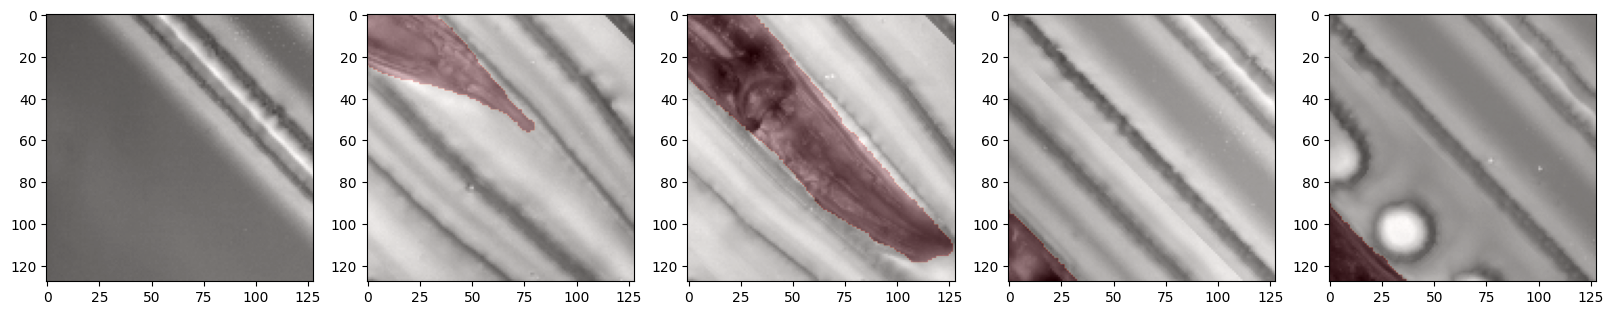

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,480)
    axs[i].imshow(im_patches_reshaped[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [17]:
pix_count_thresh = 128*128*0.05

accepted_patch_nums = [i for i,m in enumerate(mask_patches_reshaped) if np.sum(m)>pix_count_thresh]

mask_patches_reshaped = mask_patches_reshaped[accepted_patch_nums]
im_patches_reshaped = im_patches_reshaped[accepted_patch_nums]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(im_patches_reshaped, mask_patches_reshaped, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(114, 128, 128)
(38, 128, 128)


In [19]:
X_train = np.stack((X_train,), axis=-1)
y_train = np.stack((y_train,), axis=-1)

print(X_train.shape)
print(y_train.shape)

(114, 128, 128, 1)
(114, 128, 128, 1)


In [20]:
X_test = np.stack((X_test,), axis=-1)
y_test = np.stack((y_test,), axis=-1)
print(X_test.shape)
print(y_test.shape)

(38, 128, 128, 1)
(38, 128, 128, 1)


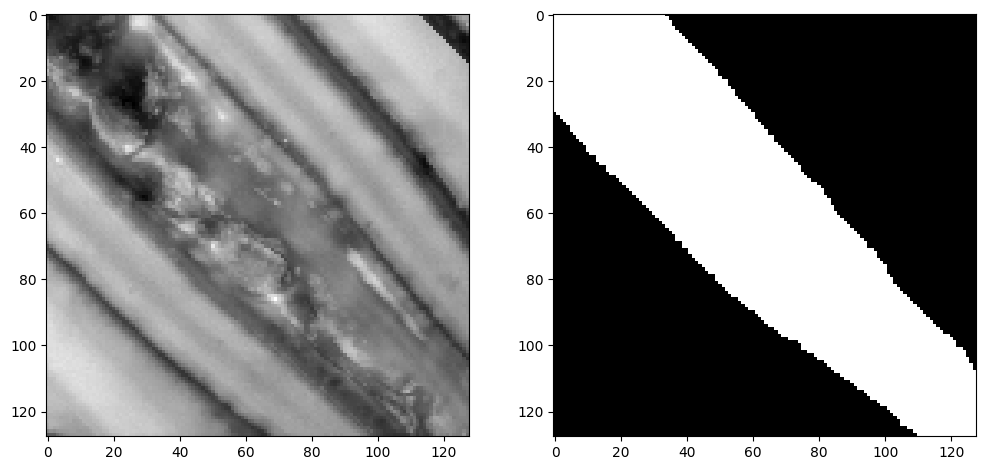

In [21]:
# sanity check
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

## Data augmentation
- Some data augmentation (flipping) is used becuase the worm can be facing either direction
- We did not use augmentation  like zoom, rotation, etc. since the worm is almost always in the same place and is the same size


In [22]:
# For some transformations you need preprocessing_function for the mask since it becomes non binary
# but I think in this case it may not be needed
seed=24
from keras.preprocessing.image import ImageDataGenerator



img_data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')



mask_data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [23]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_gen = my_image_mask_generator(image_generator,mask_generator)
test_gen = my_image_mask_generator(valid_img_generator,valid_mask_generator)

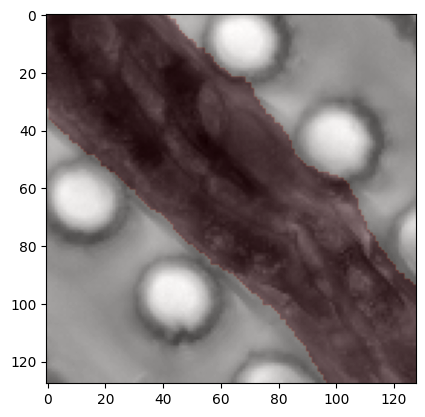

In [25]:
x = image_generator.next()
y = mask_generator.next()

i = 0
plt.imshow(x[i,...,0],'gray')
plt.imshow(y[i,...,0],'Reds',alpha = 0.2)

## Training CNNs

### Basic / Unet
- Highly simplified unet model with less layers
- optimizer='adam': popular optimization algorithm that adapts the learning rate based on the gradients of the model's parameters
- loss='binary_crossentropy': measures the dissimilarity between the predicted segmentation mask and the ground truth mask.
- metrics=[MeanIoU(num_classes=2)]: MeanIoU computes the average intersection over union value for each class. It provides a measure of the segmentation accuracy by evaluating the overlap between the predicted and ground truth masks.
- he is typically used with relu
- adding more filters helped
- adding more layers doesn't seem to be helping much

In [26]:
kernel_initializer =  'he_uniform'

In [27]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [28]:
def simplified_unet_model_smallf(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contracting path
    c1 = Conv2D(4, (3, 3), activation='relu', padding='same')(s)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(8, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Expanding path
    u3 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(p2)
    u3 = concatenate([u3, c2])

    c3 = Conv2D(8, (3, 3), activation='relu', padding='same')(u3)

    u4 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c1])

    c4 = Conv2D(4, (3, 3), activation='relu', padding='same')(u4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

    return model

In [29]:
def get_model():
    return simplified_unet_model_smallf(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [30]:
model = get_model()

model.summary()

batch_size = 16
steps_per_epoch = (len(X_train))//batch_size

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=10,
          callbacks=[tensorboard_callback])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 4)  40          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 4)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 8)    296         ['max_pooling2d[0][0]']      

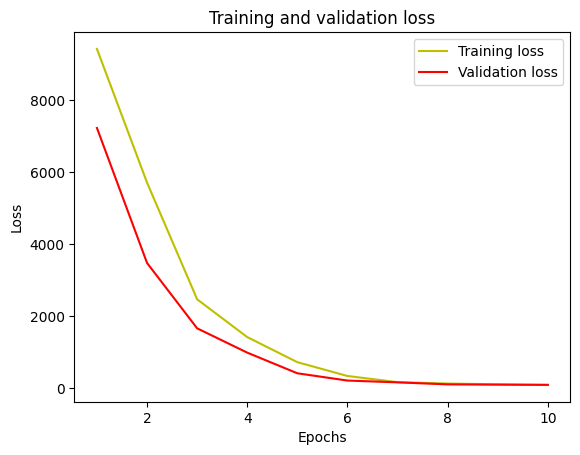

In [31]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

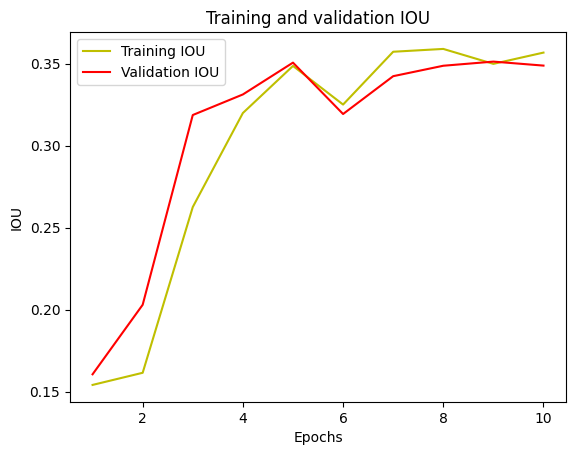

In [32]:
acc = history.history['mean_io_u']
val_acc = history.history['val_mean_io_u']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [33]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

2/2 [==============================] - 0s 7ms/step
IoU socre is:  0.0566207361560139


1/1 [==============================] - 0s 165ms/step


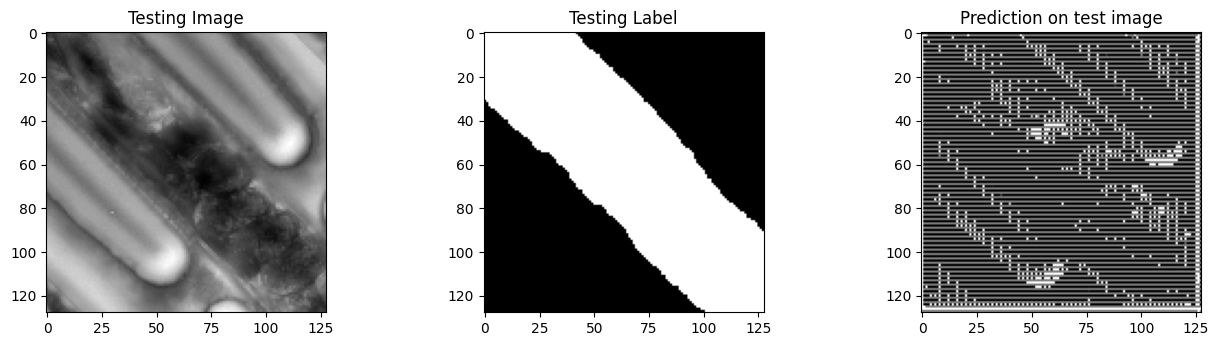

In [34]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [35]:
def simplified_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contracting path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Expanding path
    u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(p2)
    u3 = concatenate([u3, c2])

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)

    u4 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c1])

    c4 = Conv2D(16, (3, 3), activation='relu', padding='same')(u4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

    return model

In [36]:
def get_model():
    return simplified_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [37]:
model = get_model()

model.summary()

batch_size = 16
steps_per_epoch = (len(X_train))//batch_size

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=10,
          callbacks=[tensorboard_callback])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 16)  0           ['conv2d_5[0][0]']               
                                                                                            

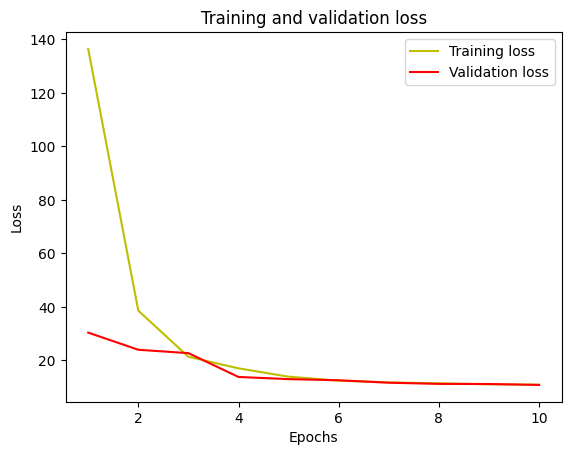

In [38]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

2/2 [==============================] - 0s 8ms/step
IoU socre is:  0.22608982403429545


1/1 [==============================] - 0s 180ms/step


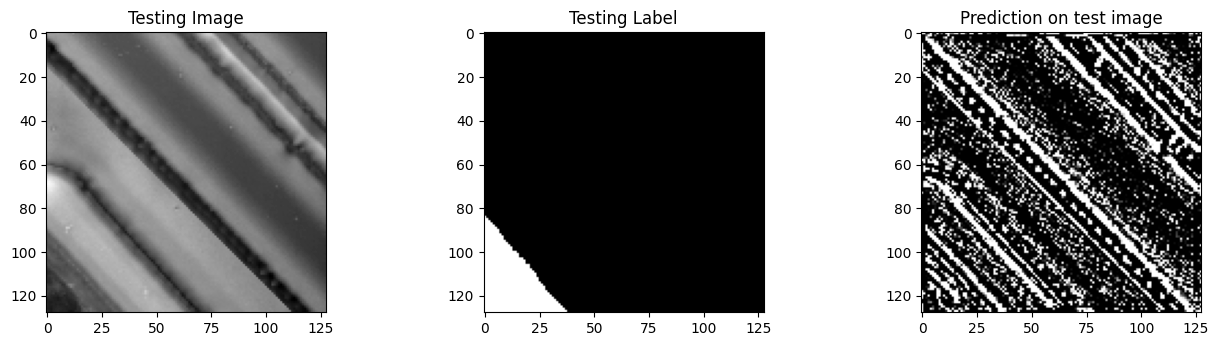

In [40]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [41]:
def less_simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)

    #Expansive path

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = concatenate([u7, c3])

    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])

    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)

    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

    model.summary()

    return model

In [42]:
def get_model():
    return less_simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [43]:
model = get_model()

model.summary()

batch_size = 16
steps_per_epoch = (len(X_train))//batch_size

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=10,
          callbacks=[tensorboard_callback])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d_10[0][0]']              
                                )                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_21[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_6 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_6[0][0]',     
                                )                                 'conv2d_11[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_6[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_6

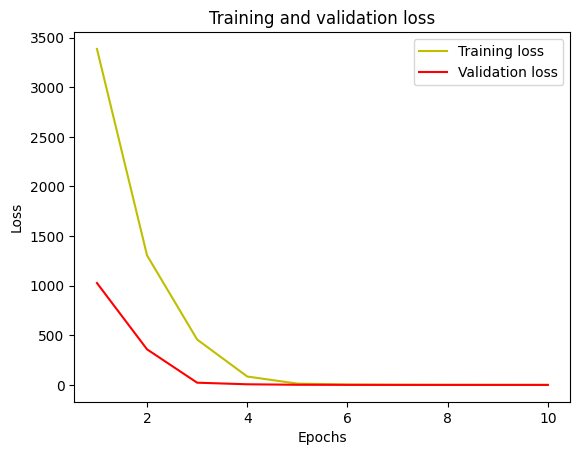

In [44]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

2/2 [==============================] - 0s 10ms/step
IoU socre is:  0.0010544762516884172


1/1 [==============================] - 0s 231ms/step


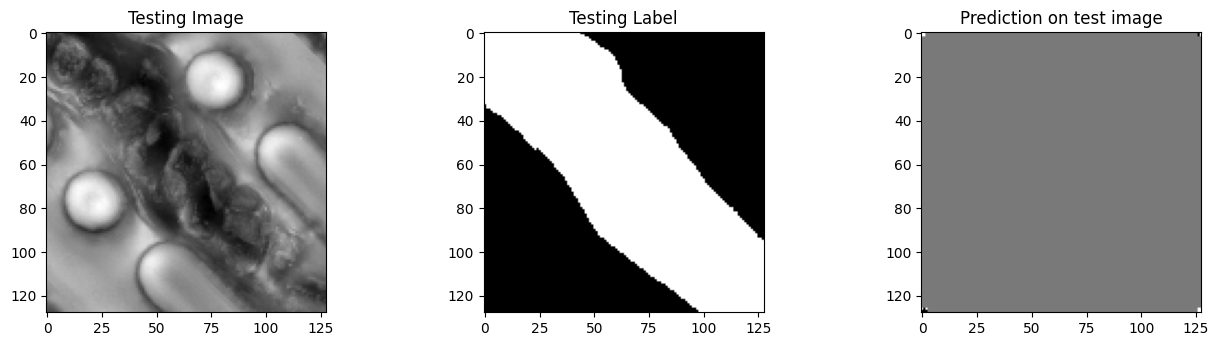

In [46]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [47]:
def orig_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    model.summary()

    return model

In [48]:
def get_model():
    return orig_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [49]:
model = get_model()

model.summary()

batch_size = 16
steps_per_epoch = (len(X_train))//batch_size

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_gen, validation_data=test_gen, steps_per_epoch=steps_per_epoch, validation_steps=steps_per_epoch, epochs=10,
          callbacks=[tensorboard_callback])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 128, 128, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 16  0           ['conv2d_25[0][0]']              
                                )                                                           

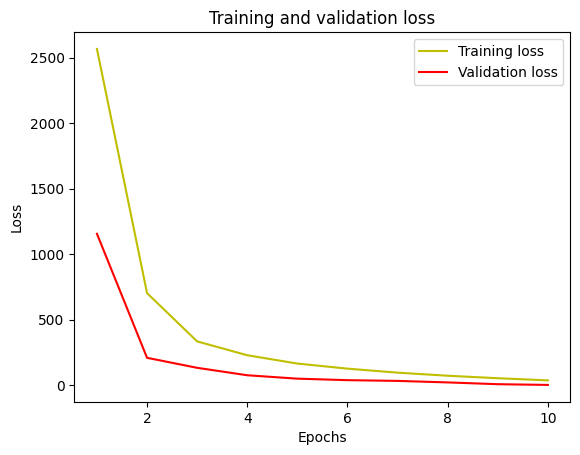

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

2/2 [==============================] - 0s 24ms/step
IoU socre is:  0.3037125065523359


1/1 [==============================] - 0s 201ms/step


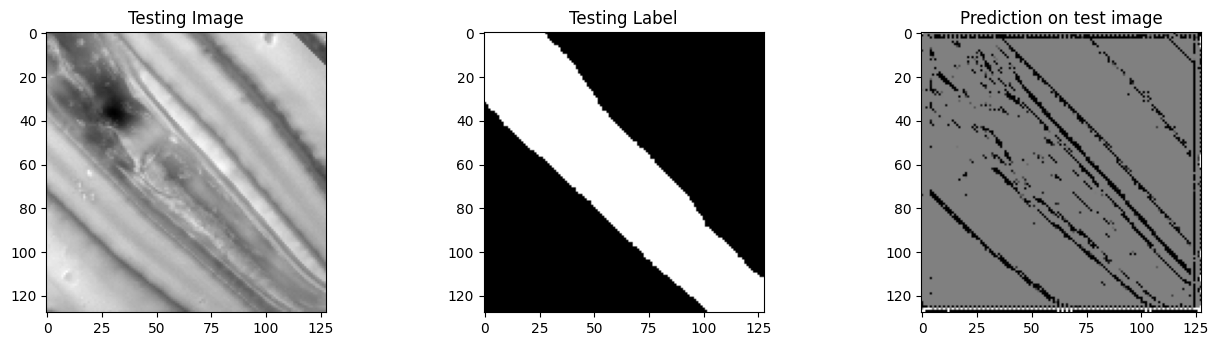

In [52]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()